In [6]:
import matplotlib.pyplot as plt
import seaborn as sns
import psycopg2 as pg
import os
import pandas as pd
from sqlalchemy import create_engine
from wordcloud import WordCloud, ImageColorGenerator
from PIL import Image
import nltk
import numpy as np
import re
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import GridSearchCV

In [7]:
sns.set_style('whitegrid')
plt.rc('font', family='Arial')
plt.rc('font', size=8) 
plt.rc('axes', titlesize=8) 
plt.rc('axes', labelsize=8) 
plt.rc('xtick', labelsize=8) 
plt.rc('ytick', labelsize=8) 
plt.rc('legend', fontsize=8)
%config InlineBackend.figure_format = 'retina'
pd.options.display.float_format = '{:.0f}'.format
pd.set_option('future.no_silent_downcasting', True)

In [8]:
df = pd.read_csv('datasets/oal_dt_dataset.csv', 
                 names=['doi', 'pm_grouptype', 'type', 'abstract', 'title', 'page', 'author_count',
                          'has_license', 'is_referenced_by_count',
                          'references_count', 'has_funder'],
                 dtype={'doi': str,
                        'pm_grouptype': str,
                        'type': str,
                        'abstract': str,
                        'title': str,
                        'page': str,
                        'author_count': int,
                        'has_license': int,
                        'is_referenced_by_count': int,
                        'references_count': int,
                        'has_funder': int
                 }, sep=',', quotechar='"', header=0, nrows=1000000)

In [9]:
df.head()

,doi,pm_grouptype,type,abstract,title,page,author_count,has_license,is_referenced_by_count,references_count,has_funder
0,10.1001/2012.jama.10425,Journal_Article,research_discourse,NaN,A Path to Wholeness,985,4,0,1,0,0
1,10.1001/2012.jama.10452,Journal_Article,research_discourse,NaN,Worries,873,1,0,1,0,0
2,10.1001/2012.jama.10500,News,editorial_discourse,NaN,Critics of US House Proposal to Ax AHRQ Say Id...,849,1,0,0,0,0
3,10.1001/2012.jama.10931,Editorial,editorial_discourse,NaN,Atherogenic Vascular Stiffness and Hypertension,919,1,0,11,0,0
4,10.1001/2012.jama.10939,News,editorial_discourse,NaN,Lessons From Massachusetts: Cost Remains a Hur...,961,1,0,1,0,0


In [10]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000000 entries, 0 to 999999
Data columns (total 11 columns):
 #   Column                  Non-Null Count    Dtype 
---  ------                  --------------    ----- 
 0   doi                     1000000 non-null  object
 1   pm_grouptype            1000000 non-null  object
 2   type                    1000000 non-null  object
 3   abstract                413301 non-null   object
 4   title                   999987 non-null   object
 5   page                    897056 non-null   object
 6   author_count            1000000 non-null  int64 
 7   has_license             1000000 non-null  int64 
 8   is_referenced_by_count  1000000 non-null  int64 
 9   references_count        1000000 non-null  int64 
 10  has_funder              1000000 non-null  int64 
dtypes: int64(5), object(6)
memory usage: 83.9+ MB


In [11]:
df.describe()

,author_count,has_license,is_referenced_by_count,references_count,has_funder
count,1000000,1000000,1000000,1000000,1000000
mean,6,1,21,42,0
std,11,0,54,38,0
min,0,0,0,0,0
25%,3,1,3,22,0
50%,5,1,10,36,0
75%,8,1,22,52,1
max,3457,1,19711,3779,1


In [12]:
pd.reset_option('float_format')

In [13]:
df.value_counts(subset=['type'], normalize=False, dropna=False)

type               
research_discourse     919150
editorial_discourse     79217
not assigned             1633
Name: count, dtype: int64

In [14]:
df.value_counts(subset=['type'], normalize=True, dropna=False)

type               
research_discourse     0.919150
editorial_discourse    0.079217
not assigned           0.001633
Name: proportion, dtype: float64

In [15]:
df.groupby(['type'])['author_count'].median()

type
editorial_discourse    3.0
not assigned           2.0
research_discourse     5.0
Name: author_count, dtype: float64

In [16]:
df.groupby(['type'])['author_count'].mean()

type
editorial_discourse    3.816087
not assigned           2.457440
research_discourse     6.404567
Name: author_count, dtype: float64

In [17]:
df.groupby(['type'])['author_count'].std()

type
editorial_discourse    14.364447
not assigned            4.126618
research_discourse     10.378191
Name: author_count, dtype: float64

In [18]:
df.groupby(['type'])['has_license'].mean()

type
editorial_discourse    0.877981
not assigned           0.946724
research_discourse     0.960025
Name: has_license, dtype: float64

In [19]:
df.groupby(['type'])['has_funder'].mean()

type
editorial_discourse    0.077837
not assigned           0.033068
research_discourse     0.406644
Name: has_funder, dtype: float64

In [20]:
df.groupby(['type'])['is_referenced_by_count'].median()

type
editorial_discourse     1.0
not assigned            1.0
research_discourse     11.0
Name: is_referenced_by_count, dtype: float64

In [21]:
df.groupby(['type'])['is_referenced_by_count'].mean()

type
editorial_discourse     4.185150
not assigned            4.270055
research_discourse     22.204891
Name: is_referenced_by_count, dtype: float64

In [22]:
df.groupby(['type'])['is_referenced_by_count'].std()

type
editorial_discourse    20.171089
not assigned           14.454796
research_discourse     55.688441
Name: is_referenced_by_count, dtype: float64

In [23]:
df.groupby(['type'])['references_count'].median()

type
editorial_discourse     5.0
not assigned            1.0
research_discourse     38.0
Name: references_count, dtype: float64

In [24]:
df.groupby(['type'])['references_count'].mean()

type
editorial_discourse     7.397099
not assigned           11.781996
research_discourse     45.425321
Name: references_count, dtype: float64

In [25]:
df.groupby(['type'])['references_count'].std()

type
editorial_discourse    11.715292
not assigned           23.460469
research_discourse     38.453860
Name: references_count, dtype: float64

In [26]:
def page_counter(page_str):
    page_int = 1
    if '-' in str(page_str):
        try:
            #page_str = re.sub('[^\d-]', '', page_str)
            page_int = int(abs(eval(page_str)))
            if page_int > 5000:
                page_int = 5000
        except:
            pass
        
    return page_int

In [27]:
df['page_count'] = df.page.apply(page_counter)
df['page_count'] = df['page_count'].astype(int)

In [28]:
df.groupby(['type'])['page_count'].median()

type
editorial_discourse    1.0
not assigned           1.0
research_discourse     8.0
Name: page_count, dtype: float64

In [29]:
df.groupby(['type'])['page_count'].mean()

type
editorial_discourse    1.562518
not assigned           6.358236
research_discourse     7.853300
Name: page_count, dtype: float64

In [30]:
df.groupby(['type'])['page_count'].std()

type
editorial_discourse     5.812773
not assigned           27.130127
research_discourse      6.592493
Name: page_count, dtype: float64

In [31]:
df['title_word_length']  = df['title'].str.split().str.len()
df['abstract_word_length']  = df['abstract'].str.split().str.len()

In [32]:
df.groupby(['type'])['title_word_length'].median()

type
editorial_discourse    11.0
not assigned            8.0
research_discourse     14.0
Name: title_word_length, dtype: float64

In [33]:
df.groupby(['type'])['title_word_length'].mean()

type
editorial_discourse    11.968121
not assigned            8.944274
research_discourse     14.070912
Name: title_word_length, dtype: float64

In [34]:
df.groupby(['type'])['title_word_length'].std()

type
editorial_discourse    6.223564
not assigned           5.558508
research_discourse     4.929619
Name: title_word_length, dtype: float64

In [35]:
df.groupby(['type'])['abstract_word_length'].median()

type
editorial_discourse     95.0
not assigned           150.0
research_discourse     206.0
Name: abstract_word_length, dtype: float64

In [36]:
df.groupby(['type'])['abstract_word_length'].mean()

type
editorial_discourse    104.808788
not assigned           150.050251
research_discourse     206.932417
Name: abstract_word_length, dtype: float64

In [37]:
df.groupby(['type'])['abstract_word_length'].std()

type
editorial_discourse    72.632540
not assigned           74.705601
research_discourse     64.364953
Name: abstract_word_length, dtype: float64

In [38]:
df['title_string_length']  = df['title'].str.len()
df['abstract_string_length']  = df['abstract'].str.len()

In [39]:
df.groupby(['type'])['title_string_length'].median()

type
editorial_discourse     85.0
not assigned            61.0
research_discourse     107.0
Name: title_string_length, dtype: float64

In [40]:
df.groupby(['type'])['title_string_length'].mean()

type
editorial_discourse     89.553904
not assigned            67.221678
research_discourse     109.849673
Name: title_string_length, dtype: float64

In [41]:
df.groupby(['type'])['title_string_length'].std()

type
editorial_discourse    46.581338
not assigned           39.834336
research_discourse     37.806241
Name: title_string_length, dtype: float64

In [42]:
df.groupby(['type'])['abstract_string_length'].median()

type
editorial_discourse     815.0
not assigned           1086.0
research_discourse     1666.0
Name: abstract_string_length, dtype: float64

In [43]:
df.groupby(['type'])['abstract_string_length'].mean()

type
editorial_discourse     907.362628
not assigned           1134.321608
research_discourse     1700.238430
Name: abstract_string_length, dtype: float64

In [44]:
df.groupby(['type'])['abstract_string_length'].std()

type
editorial_discourse    592.378530
not assigned           557.472078
research_discourse     608.952580
Name: abstract_string_length, dtype: float64

In [45]:
df['abstract'].isna().sum()

586699

In [46]:
df[df.type == 'research_discourse']['abstract'].isna().sum() / len(df[df.type == 'research_discourse'])

0.5555622042104118

In [47]:
df[df.type == 'editorial_discourse']['abstract'].isna().sum() / len(df[df.type == 'editorial_discourse'])

0.941969526742997

In [48]:
df[df.type == 'not assigned']['abstract'].isna().sum() / len(df[df.type == 'not assigned'])

0.8781383955909369

In [49]:
w_tokenizer = nltk.tokenize.WhitespaceTokenizer()
lemmatizer = nltk.stem.WordNetLemmatizer()
remove_html = re.compile('<.*?>')

def lemmatize_text(text):
    if pd.isna(text):
        text = ''
    text = str(text)
    text = text.lower()
    text = re.sub(remove_html, '', text)
    return ' '.join([lemmatizer.lemmatize(w) for w in w_tokenizer.tokenize(text)])

df['title_lemmatized'] = df.title.apply(lemmatize_text)
#df['abstract_lemmatized'] = df.abstract.apply(lemmatize_text)

In [50]:
def generate_wordcloud(data):
    cloud = WordCloud(width=700,
                      height=500,
                      max_words=150,
                      colormap='tab20c',
                      collocations=False).generate_from_text(data)
    plt.figure(figsize=(10,8))
    plt.imshow(cloud)
    plt.axis('off')
    plt.show()

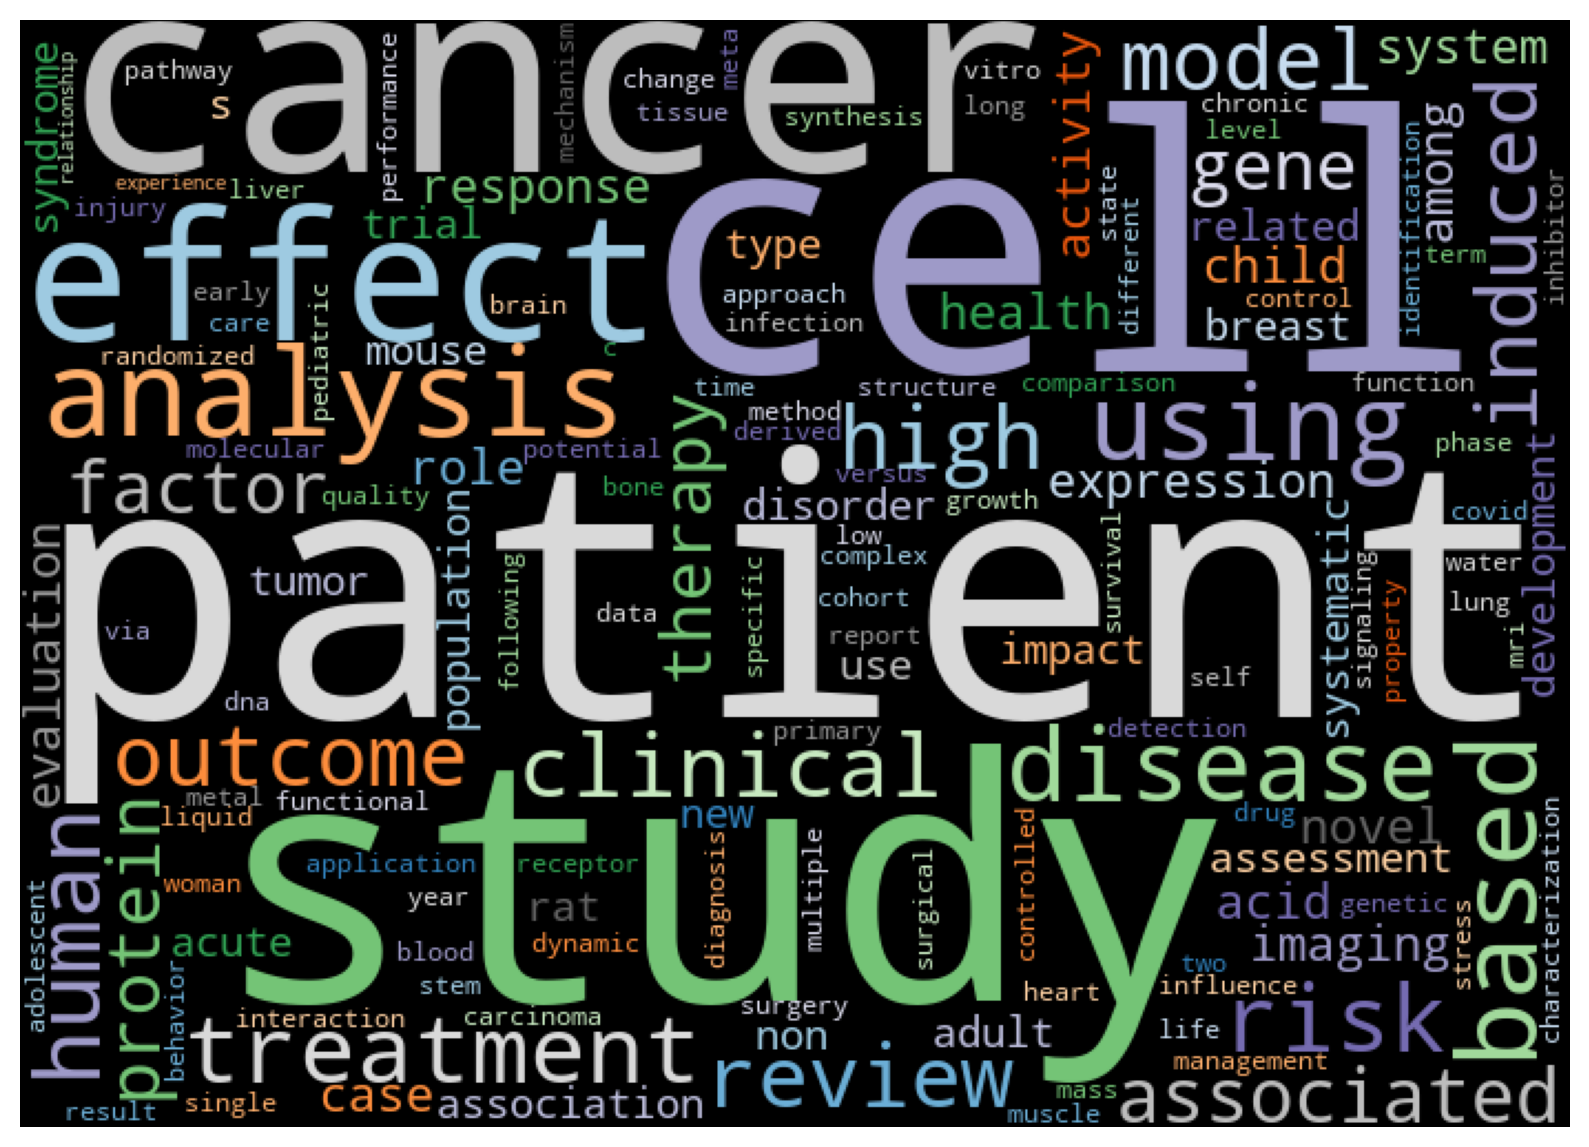

In [51]:
generate_wordcloud(' '.join(df[df.type == 'research_discourse']['title_lemmatized']))

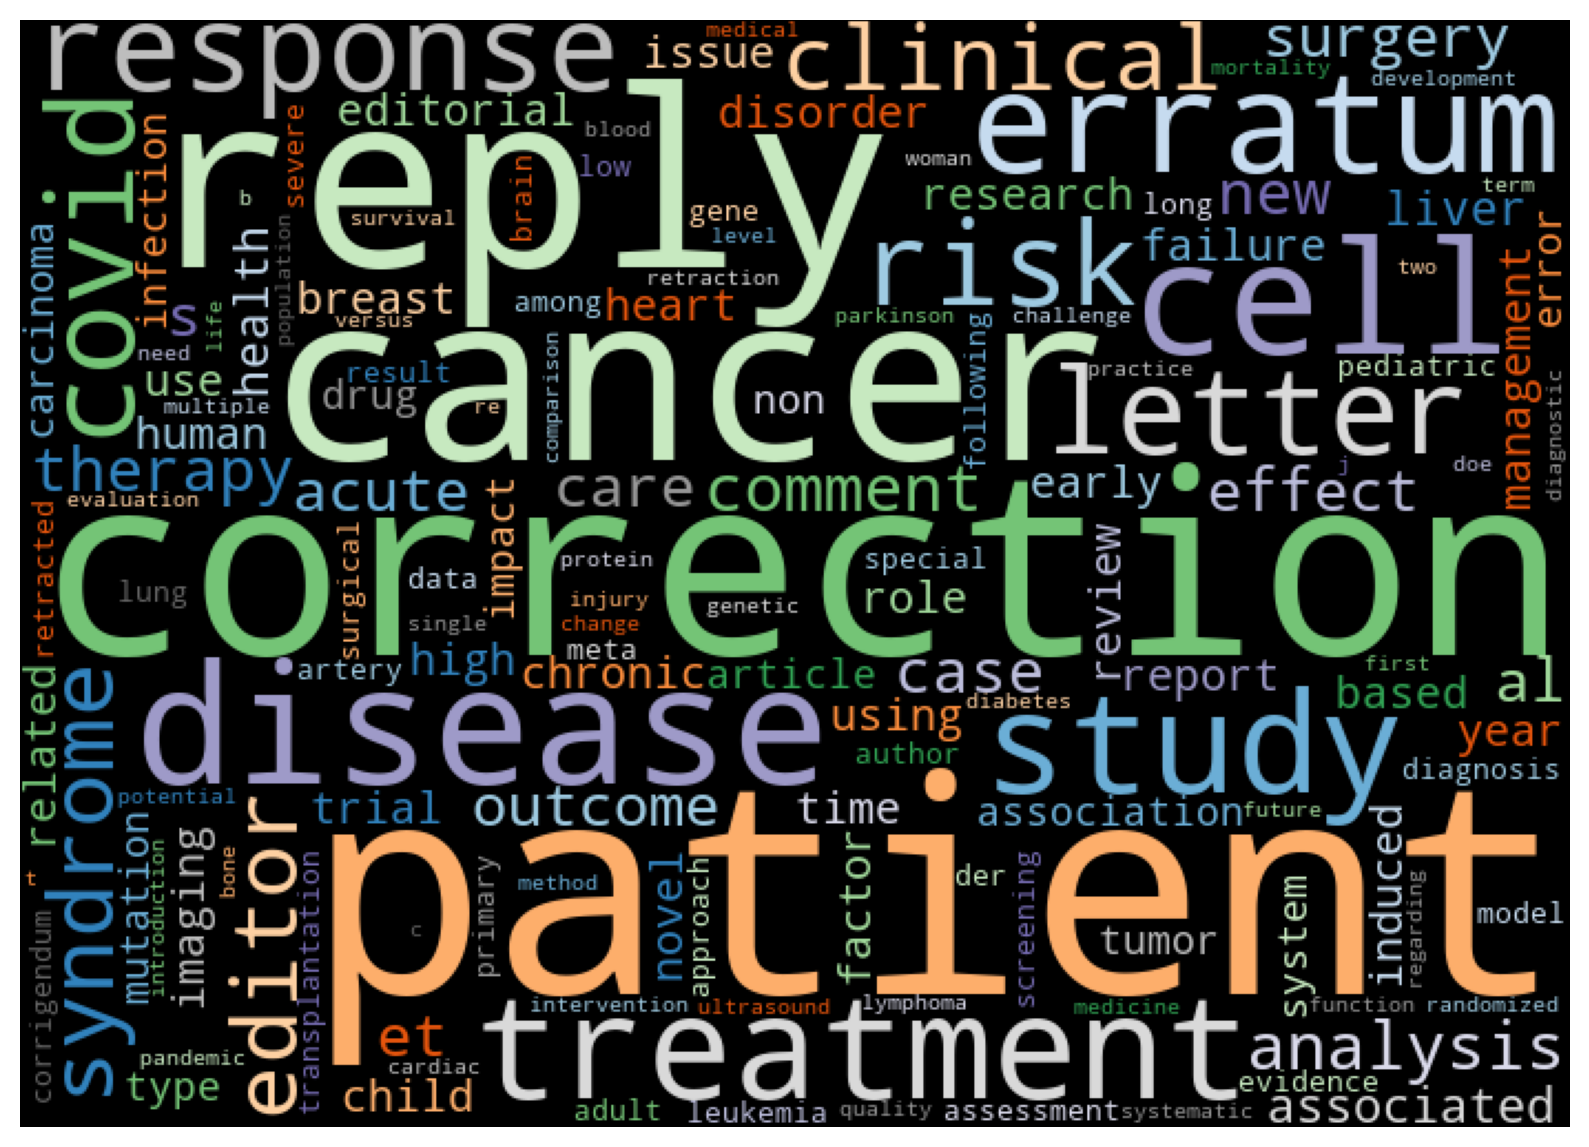

In [52]:
generate_wordcloud(' '.join(df[df.type == 'editorial_discourse']['title_lemmatized']))

In [53]:
#generate_wordcloud(' '.join(df[df.type == 'research_discourse']['abstract_lemmatized']))

In [54]:
#generate_wordcloud(' '.join(df[df.type == 'editorial_discourse']['abstract_lemmatized']))

In [6]:
host = os.environ['KB_HOST']
database = os.environ['KB_DATABASE']
user = os.environ['KB_USER']
pw = os.environ['KB_PASSWORD']
port = os.environ['KB_PORT']
engine = create_engine(f'postgresql://{user}:{pw}@{host}:{port}/{database}')

In [20]:
oal_type_oa = pd.read_sql("""
                          SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, pl.is_oa AS is_oa
                          FROM unignhaupka.oal_doc_dataset d
                          JOIN fiz_openalex_rep_20230819_openbib.works w
                              ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                          JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations pl
                              ON w.id = pl.work_id
                          GROUP BY d.type, is_oa
                          ORDER BY n DESC
                          """, 
                          con=engine)

In [28]:
oal_type_oa['prop'] = oal_type_oa['n'] / oal_type_oa.groupby(['type'])['n'].transform('sum')
oal_type_oa

,n,type,is_oa,prop
0,4688614,research_discourse,False,0.529887
1,4159719,research_discourse,True,0.470113
2,378522,editorial_discourse,True,0.513189
3,359066,editorial_discourse,False,0.486811
4,8333,not assigned,False,0.555793
5,6660,not assigned,True,0.444207


In [32]:
oal_type_oa_status = pd.read_sql("""
                                 SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, woa.oa_status
                                 FROM unignhaupka.oal_doc_dataset d
                                 JOIN fiz_openalex_rep_20230819_openbib.works w
                                     ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                                 JOIN fiz_openalex_rep_20230819_openbib.works_open_access woa
                                     ON w.id = woa.work_id
                                 GROUP BY d.type, woa.oa_status
                                 ORDER BY n DESC
                                 """, 
                                 con=engine)

In [42]:
oal_type_oa_status['prop'] = oal_type_oa_status['n'] / oal_type_oa_status.groupby(['type'])['n'].transform('sum')
oal_type_oa_status

,n,type,oa_status,prop
0,3729869,research_discourse,closed,0.421528
1,2519459,research_discourse,gold,0.284735
2,1082114,research_discourse,green,0.122294
3,899542,research_discourse,bronze,0.101661
4,617465,research_discourse,hybrid,0.069782
5,333787,editorial_discourse,closed,0.452554
6,219087,editorial_discourse,bronze,0.297042
7,110080,editorial_discourse,gold,0.149248
8,48280,editorial_discourse,green,0.065459
9,26328,editorial_discourse,hybrid,0.035696


In [45]:
oal_type_apc = pd.read_sql("""
                           SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, AVG((apc_list->>'value_usd')::numeric) AS apc
                           FROM unignhaupka.oal_doc_dataset d
                           JOIN fiz_openalex_rep_20230819_openbib.works w
                               ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                           GROUP BY d.type
                           ORDER BY n DESC
                           """, 
                           con=engine)

In [46]:
oal_type_apc

,n,type,apc
0,8847736,research_discourse,3096.029307
1,737509,editorial_discourse,3882.455098
2,14985,not assigned,4056.178471


In [53]:
oal_type_license = pd.read_sql("""
                               SELECT COUNT(DISTINCT(d.doi)) AS n, d.type AS type, pl.license as license
                               FROM unignhaupka.oal_doc_dataset d
                               JOIN fiz_openalex_rep_20230819_openbib.works w
                                   ON LOWER(TRIM('https://doi.org/' FROM w.doi)) = LOWER(d.doi)
                               JOIN fiz_openalex_rep_20230819_openbib.works_primary_locations pl
                                   ON w.id = pl.work_id
                               GROUP BY d.type, license
                               ORDER BY n DESC
                               """, 
                               con=engine)

In [59]:
oal_type_license['prop'] = (oal_type_license['n'] / oal_type_license.groupby(['type'])['n'].transform('sum')) * 100
oal_type_license.sort_values(by=['license'])

,n,type,license,prop
48,1,research_discourse,acs-specific,0.000011
29,482,editorial_discourse,acs-specific: authorchoice/editors choice usag...,0.065351
16,8159,research_discourse,acs-specific: authorchoice/editors choice usag...,0.092214
1,2095784,research_discourse,cc-by,23.686922
6,73645,editorial_discourse,cc-by,9.984977
25,903,not assigned,cc-by,6.026026
4,316148,research_discourse,cc-by-nc,3.573161
32,188,not assigned,cc-by-nc,1.254588
12,14270,editorial_discourse,cc-by-nc,1.934763
3,334125,research_discourse,cc-by-nc-nd,3.776340


In [55]:
def has_abstract(abstract_str):
    if pd.isna(abstract_str):
        return 0
    else:
        return 1

In [56]:
df['has_abstract'] = df.abstract.apply(has_abstract)
df['has_abstract'] = df['has_abstract'].astype(int)

In [57]:
df['title_string_length'] = df['title_string_length'].fillna(0)
df['abstract_string_length'] = df['abstract_string_length'].fillna(0)
df['title_word_length'] = df['title_word_length'].fillna(0)
df['abstract_word_length'] = df['abstract_word_length'].fillna(0)

In [58]:
df = df[df['type'] != 'not assigned']
df['type'] = df['type'].replace(to_replace='research_discourse', value=1)
df['type'] = df['type'].replace(to_replace='editorial_discourse', value=0)
df['type'] = df['type'].astype(int)
df = df.reset_index(drop=True)

In [59]:
X = df[['author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract']].values
y = df[['type']].values.ravel()

In [60]:
X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.25, random_state=42)

## LogisticRegression

In [61]:
classifier = LogisticRegression(max_iter=1000, random_state=42)
classifier.fit(X_train, y_train)
 
y_pred = classifier.predict(X_test)

In [62]:
print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.76      0.61      0.67     19804
 research_discourse       0.97      0.98      0.97    229788

           accuracy                           0.95    249592
          macro avg       0.86      0.80      0.82    249592
       weighted avg       0.95      0.95      0.95    249592



## OpenAlex

In [64]:
df_oal_test = pd.read_csv('datasets/oal_doctype_testset.csv')
df_oal_test = df_oal_test[df_oal_test['oaltype'] != 'not assigned']
df_oal_test = df_oal_test.reset_index(drop=True)

In [65]:
df_oal_test = df[['doi', 'type']].merge(df_oal_test, on=['doi'])

In [66]:
df_oal_test['type'] = df_oal_test['type'].replace(to_replace=1, value='research_discourse')
df_oal_test['type'] = df_oal_test['type'].replace(to_replace=0, value='editorial_discourse')

In [67]:
y_pm = df_oal_test[['type']].values.ravel()
y_oal = df_oal_test[['oaltype']].values.ravel()

In [68]:
print(classification_report(y_pm, y_oal, zero_division=1))

                     precision    recall  f1-score   support

editorial_discourse       0.99      0.06      0.12     79200
 research_discourse       0.93      1.00      0.96    918058

           accuracy                           0.93    997258
          macro avg       0.96      0.53      0.54    997258
       weighted avg       0.93      0.93      0.89    997258



## Scopus 

In [69]:
df_scp_test = pd.read_csv('datasets/scp_doctype_testset.csv')
df_scp_test = df_scp_test[df_scp_test['scptype'] != 'not assigned']
df_scp_test = df_scp_test.reset_index(drop=True)

In [70]:
df_scp_test = df[['doi', 'type']].merge(df_scp_test, on=['doi'])

In [71]:
df_scp_test['type'] = df_scp_test['type'].replace(to_replace=1, value='research_discourse')
df_scp_test['type'] = df_scp_test['type'].replace(to_replace=0, value='editorial_discourse')

In [72]:
y_pm = df_scp_test[['type']].values.ravel()
y_scp = df_scp_test[['scptype']].values.ravel()

In [73]:
print(classification_report(y_pm, y_scp, zero_division=1))

                     precision    recall  f1-score   support

editorial_discourse       0.69      0.93      0.79     59480
 research_discourse       1.00      0.97      0.98    911611

           accuracy                           0.97    971091
          macro avg       0.84      0.95      0.89    971091
       weighted avg       0.98      0.97      0.97    971091



## Dummy 

In [74]:
dummy_clf = DummyClassifier(strategy='stratified')
dummy_clf.fit(X, y)

y_pred = dummy_clf.predict(X)
print(classification_report(y, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.08      0.08      0.08     79217
 research_discourse       0.92      0.92      0.92    919150

           accuracy                           0.85    998367
          macro avg       0.50      0.50      0.50    998367
       weighted avg       0.85      0.85      0.85    998367



## RandomForest

In [75]:
from sklearn.ensemble import RandomForestClassifier

clf = RandomForestClassifier(criterion='gini', max_depth=None, max_features='sqrt', n_estimators=200, n_jobs=-1, random_state=42)
clf.fit(X_train, y_train)
 
y_pred = clf.predict(X_test)

print(classification_report(y_test, y_pred, zero_division=1, target_names=['editorial_discourse', 'research_discourse']))

                     precision    recall  f1-score   support

editorial_discourse       0.72      0.70      0.71     19804
 research_discourse       0.97      0.98      0.98    229788

           accuracy                           0.95    249592
          macro avg       0.85      0.84      0.84    249592
       weighted avg       0.95      0.95      0.95    249592



In [76]:
importances = clf.feature_importances_

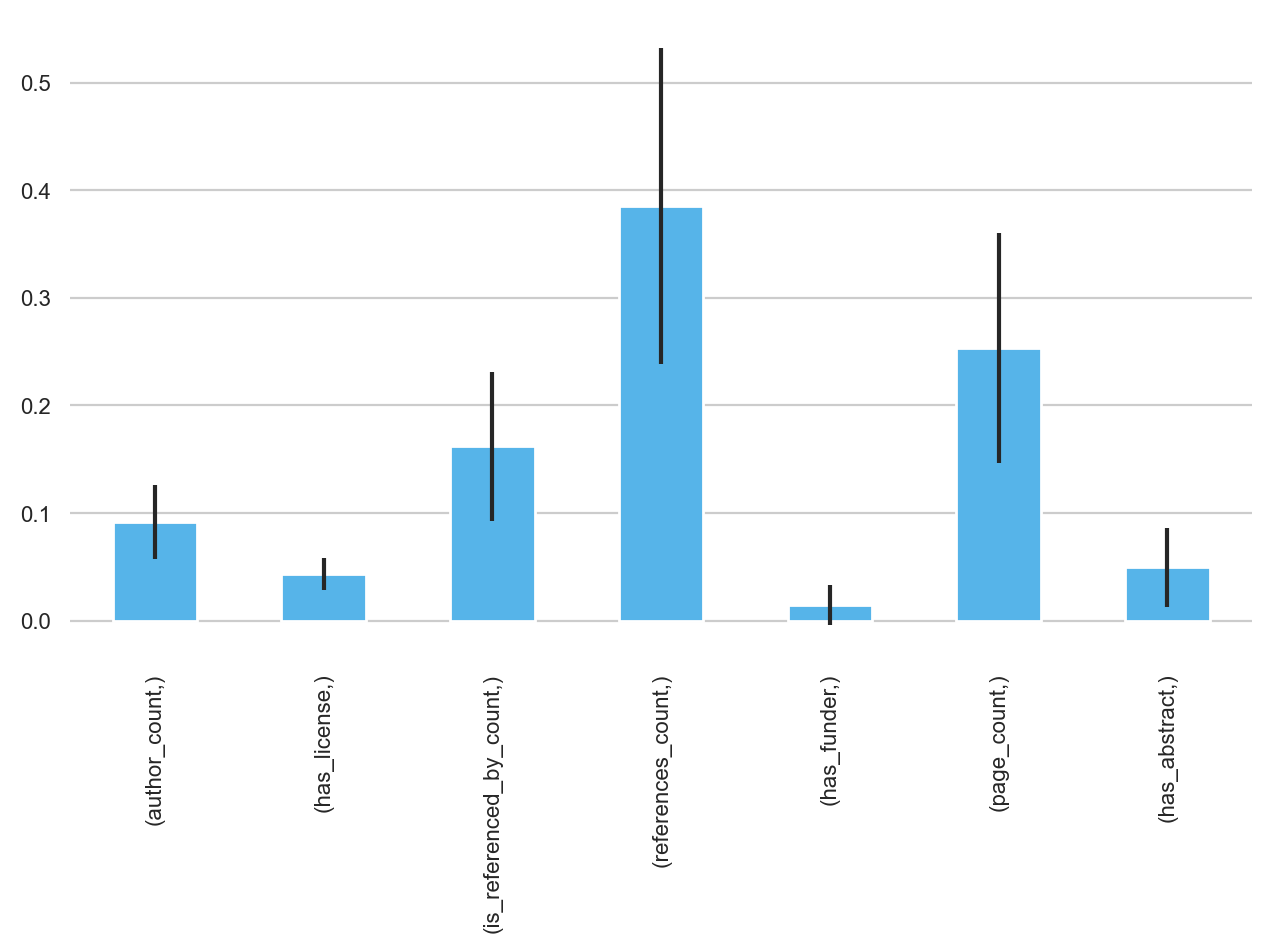

In [84]:
forest_importances = pd.Series(importances, index=[['author_count', 'has_license', 'is_referenced_by_count',
        'references_count', 'has_funder', 'page_count', 'has_abstract']])
std = np.std([tree.feature_importances_ for tree in clf.estimators_], axis=0)

fig, ax = plt.subplots()
plt.box(False)
forest_importances.plot.bar(yerr=std, ax=ax, color='#56B4E9')
ax.xaxis.grid(False)
fig.tight_layout()
plt.show()